### Task 0 Before your go

> 1. Rename Assignment-02-###.ipynb where ### is your student ID.
> 2. The deadline of Assignment-02 is 23:59pm, 04-21-2024
> 3. In this assignment, you will use word embeddings to explore our Wikipedia dataset.

### Task 1 Train word embeddings using SGNS 
> Use our enwiki-train.json as training data. You can use the [Gensim tool](https://radimrehurek.com/gensim/models/word2vec.html). But it is recommended to implement by yourself. You should explain how hyper-parameters such as dimensionality of embeddings, window size, the parameter of negative sampling strategy, and initial learning rate have been chosen.

In [16]:
# import some necessary libraries
from typing import List, Dict, Callable
from tqdm import tqdm
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import heapq


In [3]:
# load the train and test data from the json file

# NOTE: The function is inherited from my solution of assignment 1
def load_json(file_path: str) -> List:
    """
    Fetch the data from `.json` file and concat them into a list.

    Input:
    - file_path: The relative file path of the `.json` file

    Returns:
    - join_data_list: A list containing the data, with the format of [{'title':<>, 'label':<>, 'text':<>}, {}, ...]
    """
    join_data_list = []
    with open(file_path, "r") as json_file:
        for line in json_file:
            line = line.strip()
            # guaranteen the line is not empty
            if line: 
                join_data_list.append(json.loads(line))
    return join_data_list

train_file_path, test_file_path = "enwiki-train.json", "enwiki-test.json"
train_data_list, test_data_list = map(load_json, [train_file_path, test_file_path])

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import utils

class Word2VecWrapper(BaseEstimator, TransformerMixin):
    """
    Args:
    - vector_size: dimensionality of embeddings
    - window: window size
    - negative: the parameter of negative sampling strategy(size)
    - alpha: learning rate
    """
    def __init__(self, vector_size=100, window=5, negative=5, alpha=0.025):
        self.vector_size = vector_size
        self.window = window
        self.negative = negative
        self.alpha = alpha
        self.model = None

    def fit(self, X, y=None):
        """
        Train a Word2Vec model with the specified hyperparameters.
        """
        self.model = Word2Vec(
            sentences=X,
            vector_size=self.vector_size,
            window=self.window,
            negative=self.negative,
            alpha=self.alpha
        )
        return self

    def transform(self, X):
        """
        Compute the embedding of the given X, here the average of embeddings of all words in each document is used.
        """
        doc_embeddings = []
        for text in tqdm(X):
            valid_word_embeddings = [self.model.wv[word] for word in text if word in self.model.wv]
            try:
                doc_embedding = sum(valid_word_embeddings) / len(valid_word_embeddings)
            except:
                doc_embedding = np.zeros(self.vector_size)
            doc_embeddings.append(doc_embedding)
        return doc_embeddings

- For the hyper-parameters mentioned above
  - `vector_size`: dimensionality of embeddings
    - This determines the dimensionality of the word vectors.
    - Larger size: Results in richer, more detailed word embeddings but can lead to overfitting and requires more data and memory.
    - Smaller size: Results in simpler embeddings, requires less data, and is faster to train, but might not capture nuances as effectively.
    - Common choices: Typically ranges from 50 to 300, here I choose the value from [50, 75, 100]
  - `window`: window size
    - This is the maximum distance between the current word and the words in its context that the model considers.
    - Larger window: Captures broader context, resulting in embeddings that capture more semantic information.
    - Smaller window: Focuses on local context, resulting in embeddings that capture more syntactic information.
    - Common choices: Typically ranges from 2 to 10, here I choose the value from [3, 5, 7]
  - `negative`: negative sampling strategy(size)
    - This is the number of negative samples (words) to sample for each positive sample (context word).
    - Higher value: Provides more context and potentially more informative gradients, but increases computational cost.
    - Lower value: Reduces computation and may train faster but can be less effective in learning good embeddings.
    - Common choices: Typically ranges from 5 to 20, here I choose the value from [5, 10]
  - `alpha`: initial learning rate 
    - This is the initial learning rate for the model.
    - Higher rate: Speeds up convergence but may cause the model to overshoot the optimal values.
    - Lower rate: Slows down convergence but may lead to more stable training and better results.
    - Common choices: Typically ranges from 0.01 to 0.1, here I choose the value from [0.01, 0.025, 0.05]


In [18]:
import warnings
warnings.filterwarnings("ignore")

sentence = [utils.simple_preprocess(line["text"]) for line in train_data_list]
labels = [line["label"] for line in train_data_list]

param_grid = {
    'word2vec__vector_size': [50, 75, 100],
    'word2vec__window': [3, 5, 7],
    'word2vec__negative': [5, 10],
    'word2vec__alpha': [0.01, 0.025, 0.05]
}

pipeline = Pipeline([
    ('word2vec', Word2VecWrapper()),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=120))
])

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=3) # error_score="raise"
grid_search.fit(sentence, labels)

# reset the warning status
warnings.filterwarnings("default")

Fitting 5 folds for each of 54 candidates, totalling 270 fits


100%|██████████| 200/200 [00:02<00:00, 72.11it/s] 


[CV 1/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=3;, score=0.875 total time=  29.1s


100%|██████████| 200/200 [00:02<00:00, 97.71it/s] 


[CV 2/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=3;, score=0.880 total time=  23.2s


100%|██████████| 200/200 [00:01<00:00, 112.64it/s]


[CV 3/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=3;, score=0.875 total time=  24.8s


100%|██████████| 200/200 [00:01<00:00, 104.88it/s]


[CV 4/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=3;, score=0.885 total time=  27.1s


100%|██████████| 200/200 [00:01<00:00, 115.98it/s]


[CV 5/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=3;, score=0.870 total time=  26.7s


100%|██████████| 200/200 [00:03<00:00, 63.40it/s] 


[CV 1/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=5;, score=0.890 total time=  24.5s


100%|██████████| 200/200 [00:02<00:00, 86.10it/s] 


[CV 2/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=5;, score=0.875 total time=  25.4s


100%|██████████| 200/200 [00:01<00:00, 100.52it/s]


[CV 3/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=5;, score=0.890 total time=  26.1s


100%|██████████| 200/200 [00:01<00:00, 111.33it/s]


[CV 4/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=5;, score=0.890 total time=  26.4s


100%|██████████| 200/200 [00:01<00:00, 110.90it/s]


[CV 5/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=5;, score=0.875 total time=  27.2s


100%|██████████| 200/200 [00:02<00:00, 69.32it/s] 


[CV 1/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=7;, score=0.890 total time=  51.8s


100%|██████████| 200/200 [00:02<00:00, 92.09it/s] 


[CV 2/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=7;, score=0.895 total time=  30.8s


100%|██████████| 200/200 [00:01<00:00, 104.38it/s]


[CV 3/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=7;, score=0.900 total time=  26.9s


100%|██████████| 200/200 [00:01<00:00, 108.97it/s]


[CV 4/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=7;, score=0.905 total time=  30.9s


100%|██████████| 200/200 [00:01<00:00, 118.78it/s]


[CV 5/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=50, word2vec__window=7;, score=0.875 total time=  27.0s


100%|██████████| 200/200 [00:02<00:00, 70.85it/s] 


[CV 1/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=3;, score=0.885 total time=  24.5s


100%|██████████| 200/200 [00:02<00:00, 88.33it/s] 


[CV 2/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=3;, score=0.875 total time=  26.8s


100%|██████████| 200/200 [00:02<00:00, 99.87it/s] 


[CV 3/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=3;, score=0.870 total time=  26.6s


100%|██████████| 200/200 [00:01<00:00, 115.10it/s]


[CV 4/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=3;, score=0.895 total time=  27.0s


100%|██████████| 200/200 [00:01<00:00, 127.31it/s]


[CV 5/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=3;, score=0.885 total time=  26.3s


100%|██████████| 200/200 [00:03<00:00, 60.30it/s] 


[CV 1/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=5;, score=0.895 total time=  25.6s


100%|██████████| 200/200 [00:02<00:00, 88.18it/s] 


[CV 2/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=5;, score=0.875 total time=  40.2s


100%|██████████| 200/200 [00:02<00:00, 86.48it/s] 


[CV 3/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=5;, score=0.895 total time=  26.8s


100%|██████████| 200/200 [00:01<00:00, 111.78it/s]


[CV 4/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=5;, score=0.900 total time=  26.8s


100%|██████████| 200/200 [00:01<00:00, 114.59it/s]


[CV 5/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=5;, score=0.875 total time=  31.2s


100%|██████████| 200/200 [00:03<00:00, 62.84it/s] 


[CV 1/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=7;, score=0.900 total time=  30.3s


100%|██████████| 200/200 [00:02<00:00, 87.95it/s] 


[CV 2/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=7;, score=0.890 total time=  27.3s


100%|██████████| 200/200 [00:01<00:00, 113.62it/s]


[CV 3/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=7;, score=0.905 total time=  25.2s


100%|██████████| 200/200 [00:01<00:00, 112.01it/s]


[CV 4/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=7;, score=0.905 total time=  26.9s


100%|██████████| 200/200 [00:02<00:00, 97.28it/s] 


[CV 5/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=75, word2vec__window=7;, score=0.880 total time=  30.0s


100%|██████████| 200/200 [00:03<00:00, 59.63it/s] 


[CV 1/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=3;, score=0.880 total time=  28.0s


100%|██████████| 200/200 [00:02<00:00, 89.15it/s] 


[CV 2/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=3;, score=0.885 total time=  27.1s


100%|██████████| 200/200 [00:01<00:00, 108.39it/s]


[CV 3/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=3;, score=0.875 total time=  26.6s


100%|██████████| 200/200 [00:01<00:00, 118.24it/s]


[CV 4/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=3;, score=0.885 total time=  25.5s


100%|██████████| 200/200 [00:01<00:00, 116.38it/s]


[CV 5/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=3;, score=0.890 total time=  31.5s


100%|██████████| 200/200 [00:02<00:00, 71.67it/s] 


[CV 1/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=5;, score=0.885 total time=  25.6s


100%|██████████| 200/200 [00:02<00:00, 84.11it/s] 


[CV 2/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=5;, score=0.875 total time=  26.5s


100%|██████████| 200/200 [00:01<00:00, 112.85it/s]


[CV 3/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=5;, score=0.900 total time=  25.5s


100%|██████████| 200/200 [00:02<00:00, 99.90it/s] 


[CV 4/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=5;, score=0.900 total time=  26.6s


100%|██████████| 200/200 [00:01<00:00, 112.78it/s]


[CV 5/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=5;, score=0.880 total time=  28.7s


100%|██████████| 200/200 [00:03<00:00, 65.45it/s] 


[CV 1/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=7;, score=0.900 total time=  26.1s


100%|██████████| 200/200 [00:07<00:00, 27.68it/s] 


[CV 2/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=7;, score=0.890 total time=  52.0s


100%|██████████| 200/200 [00:06<00:00, 33.08it/s] 


[CV 3/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=7;, score=0.910 total time= 1.3min


100%|██████████| 200/200 [00:01<00:00, 117.08it/s]


[CV 4/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=7;, score=0.905 total time= 1.1min


100%|██████████| 200/200 [00:05<00:00, 39.47it/s] 


[CV 5/5] END word2vec__alpha=0.01, word2vec__negative=5, word2vec__vector_size=100, word2vec__window=7;, score=0.880 total time= 1.1min


100%|██████████| 200/200 [00:09<00:00, 21.44it/s]


[CV 1/5] END word2vec__alpha=0.01, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=3;, score=0.880 total time= 1.4min


100%|██████████| 200/200 [00:06<00:00, 29.30it/s] 


[CV 2/5] END word2vec__alpha=0.01, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=3;, score=0.890 total time= 1.5min


100%|██████████| 200/200 [00:06<00:00, 32.84it/s] 


[CV 3/5] END word2vec__alpha=0.01, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=3;, score=0.880 total time= 1.5min


100%|██████████| 200/200 [00:05<00:00, 36.20it/s] 


[CV 4/5] END word2vec__alpha=0.01, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=3;, score=0.905 total time= 1.6min


100%|██████████| 200/200 [00:05<00:00, 38.50it/s] 


[CV 5/5] END word2vec__alpha=0.01, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=3;, score=0.875 total time= 1.6min


100%|██████████| 200/200 [00:09<00:00, 21.63it/s]


[CV 1/5] END word2vec__alpha=0.01, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=5;, score=0.900 total time= 1.4min


100%|██████████| 200/200 [00:07<00:00, 27.28it/s]


[CV 2/5] END word2vec__alpha=0.01, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=5;, score=0.890 total time= 1.5min


100%|██████████| 200/200 [00:01<00:00, 119.17it/s]


[CV 3/5] END word2vec__alpha=0.01, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=5;, score=0.910 total time=  46.1s


100%|██████████| 200/200 [00:01<00:00, 122.65it/s]


[CV 4/5] END word2vec__alpha=0.01, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=5;, score=0.905 total time=  33.6s


100%|██████████| 200/200 [00:01<00:00, 133.14it/s]


[CV 5/5] END word2vec__alpha=0.01, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=5;, score=0.875 total time=  35.6s


100%|██████████| 200/200 [00:02<00:00, 74.42it/s] 


[CV 1/5] END word2vec__alpha=0.01, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=7;, score=0.910 total time=  29.2s


100%|██████████| 200/200 [00:02<00:00, 94.48it/s] 


[CV 2/5] END word2vec__alpha=0.01, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=7;, score=0.890 total time=  32.1s


100%|██████████| 200/200 [00:01<00:00, 112.02it/s]


[CV 3/5] END word2vec__alpha=0.01, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=7;, score=0.910 total time=  33.7s


100%|██████████| 200/200 [00:05<00:00, 34.62it/s] 


[CV 4/5] END word2vec__alpha=0.01, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=7;, score=0.915 total time= 1.3min


100%|██████████| 200/200 [00:01<00:00, 130.78it/s]


[CV 5/5] END word2vec__alpha=0.01, word2vec__negative=10, word2vec__vector_size=50, word2vec__window=7;, score=0.885 total time= 1.2min


100%|██████████| 200/200 [00:03<00:00, 63.87it/s] 


[CV 1/5] END word2vec__alpha=0.01, word2vec__negative=10, word2vec__vector_size=75, word2vec__window=3;, score=0.890 total time=  30.0s


100%|██████████| 200/200 [00:02<00:00, 94.80it/s] 


[CV 2/5] END word2vec__alpha=0.01, word2vec__negative=10, word2vec__vector_size=75, word2vec__window=3;, score=0.895 total time=  32.9s


In [ ]:
# print out the best parameters of the Word2Vec model
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print(f"Best parameters of the Word2Vec model: {best_params}")

# use the best parameters to fit the Word2Vec model
model = Word2Vec(
    sentence, 
    vector_size=best_params["word2vec__vector_size"], window=best_params["word2vec__window"], 
    negative=best_params["word2vec__negative"], alpha=best_params["word2vec__alpha"]
)

From the result of the `GridSearchCV` above, we can find that the best parameters for the `Word2Vec` model in the training dataset is
```python
best_params = {

}
```

### Task 2 Find similar/dissimilar word pairs

> Randomly generate 100, 1000, and 10000-word pairs from the vocabularies. For each set, print 5 closest word pairs and 5 furthest word pairs (you can use cosine-similarity to measure two words). Explain your results.

In [ ]:
def generate_random_paris(samples: int):
    """
    Generate random indices without replacement, then pairs the indices to get word pairs
    """
    indices = random.sample(range(len(model.wv)), 2 * samples)
    indices1, indices2 = indices[:samples], indices[samples:]
    return [model.wv.index_to_key[i] for i in indices1], [model.wv.index_to_key[i] for i in indices2]

def find_closest_furthest(num: int=5, words1: List[str]=None, words2: List[str]=None) -> None:
    """
    Find the cloest/furthest word pairs using `model.wv.similarity`.

    Here a heap queue is used to reduce time complexity to $O(n\log k)$, where k denotes the `num`
    """
    heap = []
    for i in range(len(words1)):
        # compute the similarity and push it into the heap
        heapq.heappush(heap, (model.wv.similarity(words1[i], words2[i]), words1[i], words2[i]))
    return heapq.nlargest(num, heap), heapq.nsmallest(num, heap)[::-1]

def print_word_pairs(results: List[tuple], flag: str) -> None:
    """
    Print the result in formatted string
    """
    print("The 5 {:>8} word pairs:".format(flag))
    for result in results:
       print("Word pairs: ({:>15}, {:>15}) --> Similarity: {:>8.6f}".format(result[1], result[2], result[0]))


random.seed(408)
pairs = [100, 1000, 10000]
for pair in pairs:
    print("For {:>5} random pairs from the vocabularies:".format(pair))
    cloest, furthest = find_closest_furthest(5, *generate_random_paris(pair))
    print_word_pairs(cloest, "closest")
    print_word_pairs(furthest, "furthest")
    print("-" * 70)

For   100 random pairs from the vocabularies:
The 5  closest word pairs:
Word pairs: (      herodotus,       sorcerers) --> Similarity: 0.903973
Word pairs: (stereotypically,             een) --> Similarity: 0.852052
Word pairs: (        bruxing,        plumbers) --> Similarity: 0.845200
Word pairs: (           sown,     prohibitive) --> Similarity: 0.844422
Word pairs: (         shaded,           booby) --> Similarity: 0.843846
The 5 furthest word pairs:
Word pairs: (       superman,         outputs) --> Similarity: 0.224095
Word pairs: (  manifestation,        homeless) --> Similarity: 0.220755
Word pairs: (     violations,         yevgeny) --> Similarity: 0.201650
Word pairs: (     separately,       communism) --> Similarity: 0.190522
Word pairs: (        trapped,          arabia) --> Similarity: 0.161391
----------------------------------------------------------------------
For  1000 random pairs from the vocabularies:
The 5  closest word pairs:
Word pairs: (        itching,       

### Task 3 Present a document as an embedding

> For each document, you have several choices to generate document embedding: 1. Use the average of embeddings of all words in each document; 2. Use the first paragraph’s words and take an average on these embeddings; 3. Use the doc2vec algorithm to present each document. Do the above for both training and testing dataset

In [ ]:
####################################################################################
###        1. Use the average of embeddings of all words in each document        ###
####################################################################################
def print_document_embeddings(embeddings: Dict, display: int=3) -> None:
    """
    Print the first `display` embeddings, default value is 3
    """
    count = 0
    for embedding, title in embeddings:
        if count >= display:
            break
        count += 1
        print("Title: {}\nEmbedding: {}".format(title, embedding))
        print("-" * 70)

def print_training_testing(method: Callable):
    """
    Print the embeddings for training and testing dataset
    """
    print("For the training dataset:")
    print_document_embeddings(method())
    print("-" * 70)
    print("For the  testing dataset:")
    print_document_embeddings(method(test_data_list))

def average_all_words(data_list: List[Dict]=train_data_list, mode: str="title") -> List[tuple]:
    doc_embeddings = []
    if mode not in ["title", "label"]:
        raise ValueError("Please input a valid mode: ['title', 'label']")
    for line in data_list:
        line_text = utils.simple_preprocess(line["text"]) # preprocess the text as in class `Corpus`
        # doc title/label and doc embedding computed by averaging all words embeddings
        doc_info = line[mode]
        valid_word_embeddings = [model.wv[word] for word in line_text if word in model.wv]
        try:
            doc_embedding = sum(valid_word_embeddings) / len(valid_word_embeddings)
        except:
            doc_embedding = np.zeros(model.vector_size)
        # store the information in a dictionary
        doc_embeddings.append((doc_embedding, doc_info))

    return doc_embeddings

print_training_testing(average_all_words)


For the training dataset:
Title: Citizen_Kane
Embedding: [-0.2663954  -0.1731534   0.14529797  0.14468351 -0.18082298 -0.3588556
  0.16558278  0.36233783 -0.2249088  -0.20275919  0.02115764 -0.3886256
 -0.06630329  0.01145506  0.11387112 -0.13366188  0.27319115  0.02631744
 -0.0997564  -0.27851948  0.03362533  0.18397567  0.06808995  0.00756407
 -0.03342935  0.20001242 -0.324267    0.2176487  -0.12200429 -0.1594112
 -0.02553948  0.16315614 -0.02247829 -0.1309481  -0.07343864  0.16178776
 -0.17263176 -0.10710631  0.00420225 -0.19978166 -0.02847863 -0.23174918
 -0.36820734 -0.09826371  0.34303558 -0.06662643 -0.13262326 -0.08773747
  0.19401594 -0.0901439   0.16267914 -0.12875661 -0.12458084 -0.04165357
 -0.12877958  0.04204509 -0.09000392  0.10812481  0.0306489   0.12577629
  0.0881409   0.1779789   0.04871433  0.00207678  0.06010904  0.04903251
 -0.15027961  0.32417786 -0.19648817  0.22387375  0.08578365  0.20574783
  0.13417637 -0.04113415  0.10624132  0.26739687 -0.02797071  0.027593

In [ ]:
####################################################################################
###  2. Use the first paragraph’s words and take an average on these embeddings  ###
####################################################################################
def find_first_paragraph(text: str):
    return text.split("\n")[0]

def average_first_para_words(data_list: List[Dict]=train_data_list, mode: str="title") -> List[tuple]:
    doc_embeddings = []
    if mode not in ["title", "label"]:
        raise ValueError("Please input a valid mode: ['title', 'label']")
    for line in data_list:
        doc_info = line[mode]
        valid_word_embeddings = [model.wv[word] for word in utils.simple_preprocess(find_first_paragraph(line["text"])) if word in model.wv]
        # since the number of words in the first paragraph is so small, it may occur `ZeroDivisonError` in the computation, here I use a 
        # try-except flow to handle this exception
        try:
            doc_embedding = sum(valid_word_embeddings) / len(valid_word_embeddings)
        except:
            doc_embedding = np.zeros(model.vector_size)
        doc_embeddings.append((doc_embedding, doc_info))

    return doc_embeddings

print_training_testing(average_first_para_words)

For the training dataset:
Title: Citizen_Kane
Embedding: [-0.31013918 -0.13307782  0.21626303  0.14614709 -0.17008995 -0.41245642
  0.18640971  0.35122702 -0.25281572 -0.22811817 -0.05751883 -0.36607233
 -0.07990082 -0.07800091  0.09233619 -0.21623607  0.32663524 -0.04767095
 -0.14089862 -0.24805255 -0.06339519  0.29589674  0.04157769 -0.06560948
 -0.00783077  0.21936283 -0.32344824  0.1945333  -0.1320983  -0.09718323
 -0.04201636  0.17388369 -0.06152294 -0.09082544 -0.08156729  0.19772752
 -0.28513244 -0.08893629 -0.0651049  -0.17524569 -0.00836113 -0.28970253
 -0.366475   -0.07503923  0.36081252 -0.05482946 -0.06545592 -0.04464293
  0.06127816 -0.05629882  0.21793216 -0.06705306 -0.09759706 -0.02308865
 -0.13761774 -0.07045555 -0.08798928  0.11947769  0.03087265  0.11284903
  0.10308851  0.2580689   0.07381936 -0.03766742  0.0491959   0.02953647
 -0.09965305  0.3976424  -0.20637207  0.22015221  0.06375545  0.14802283
  0.17551698 -0.08329308  0.05378101  0.2212795  -0.07133433  0.028

In [ ]:
####################################################################################
###             3. Use the doc2vec algorithm to present each document            ###
####################################################################################
def build_doc2vec() -> Doc2Vec:
    """
    Build the `Doc2Vec` model based on the `train_data_list`
    """
    preprocessed_text = [utils.simple_preprocess(line["text"]) for line in train_data_list]
    tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(preprocessed_text)]
    model = Doc2Vec(vector_size=model.vector_size, window=model.window, alpha=model.alpha, negative=model.negative)
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    return model

doc2vec_model = build_doc2vec()

def doc2vec_model_embeddings(data_list: List[Dict]=train_data_list, mode: str="title") -> List[tuple]:
    embeddings = []
    if mode not in ["title", "label"]:
        raise ValueError("Please input a valid mode: ['title', 'label']")
    if data_list == train_data_list:
        for index, line in enumerate(data_list):
            embeddings.append((doc2vec_model.dv[str(index)], line[mode]))
    else:
        for line in data_list:
            embeddings.append((doc2vec_model.infer_vector(line["text"].split()), line[mode]))
    return embeddings

print_training_testing(doc2vec_model_embeddings)

For the training dataset:
Title: Citizen_Kane
Embedding: [-0.52319926  1.2466848  -0.76217866  0.01917484  0.03836508  1.8196704
  0.4536157   3.1619585   0.39069685 -1.9696103   3.652593    2.297816
 -1.0494086  -3.2000036  -1.3698536  -3.9307008   1.2070763   3.5421484
 -3.2071974  -0.90947694  0.7059344  -0.14071342  0.28548837  1.6803199
  0.74323446 -1.8146906  -3.416471   -2.2008274   0.94213766 -3.317337
 -3.0214267   1.6641841  -1.1267098   0.1284957   1.7825282  -1.6913089
  1.5785105  -4.6062055  -3.4010727   4.8737497   1.8833514   0.51500267
  0.4786539   0.5791871   0.3756854  -1.9950415   0.34664825  1.2155433
 -2.1738136   0.4968373   4.5463257   2.5045595   0.5130534   1.3609918
  4.5608234   1.6303096  -0.24150999  2.7478788  -2.98685    -1.1967324
 -2.6863253   2.922834    1.0863764  -0.8298646   0.07550161  0.4174008
  0.4069463  -0.29000762 -0.31499916 -1.668088   -4.4457846   1.9932562
 -2.60246    -2.624321   -1.9292685   3.623128    4.2322783  -2.3352122
  1.1715

### Task 4 Build classifier to test docs
> Build softmax regression model to classifier testing documents based on these training doc embeddings. Does it getting better than Naive Bayes'? (You have 3 models.)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

class softmaxModel:
    def __init__(self, data: List[Dict], method: Callable) -> None:
        self.X = None
        self.y = None
        self.label_to_index = {}
        self.__model = None
        self.__ytest = None
        self.__ypred = None
        self.__method = method               # the three different models in task 3
        self.__train(method(data, "label"))  # use `method(data)` to get the embedding

    def __train(self, embedding: List[tuple]):
        """
        Train a softmax classifier based on the embedding in train data
        """
        self.X, self.y = self.__decode(embedding)
        self.__model = LogisticRegression(multi_class="multinomial", solver="lbfgs").fit(self.X, self.y)

    def __decode(self, embedding: List[tuple]) -> tuple:
        X, y = map(list, zip(*embedding))
        X, y =  map(np.array, [X, y])
        for index, label in enumerate(y):
            self.label_to_index[label] = index
        return X, y

    def predict(self, test_data: List[Dict]) -> List:
        """
        Return the predicted value of y based on the trained model and given test data
        """
        test_embedding = self.__method(test_data, "label")
        X_test, y_test = self.__decode(test_embedding)
        self.__ytest = y_test
        self.__ypred = self.__model.predict(X_test)
        return self.__ypred

    def accuracy(self) -> float:
        """
        Calculate and return the accuracy of the model in testing dataset
        """
        return accuracy_score(self.__ytest, self.__ypred)
    
    def tsne_plot(self, samples: int=24, perplexity: float=30, n_iter: int=1000) -> None:
        """
        Use t-SNE to project training document embeddings into 2d and plot them out for each of the above choices
        """
        tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity, n_iter=n_iter)
        Z = tsne.fit_transform(self.X)
        labels = set(self.y)
        # find the title
        _, titles = self.__decode(self.__method(train_data_list, "title"))
        # plot the scatter
        plt.figure(figsize=(12, 12))
        for i, label in enumerate(labels):
            indices = [j for j, y_label in enumerate(self.y) if y_label == label]
            plt.scatter(Z[indices, 0], Z[indices, 1], label=label)
        # plot the annotation
        random.seed(0)
        selected_indices = random.sample(list(range(len(self.y))), samples)
        for i in selected_indices:
            plt.annotate(titles[i], (Z[i, 0], Z[i, 1]))
        plt.legend()
        plt.show()


methods = {
    "Use the average of embeddings of all words in each document": average_all_words, 
    "Use the first paragraph’s words and take an average on these embeddings": average_first_para_words, 
    "Use the doc2vec algorithm to present each document": doc2vec_model_embeddings
}

models = {}

random.seed(411)
for text, method in methods.items():
    softmax_model = softmaxModel(train_data_list, method)
    softmax_model.predict(test_data_list)
    print("Model: {:>71}, accuracy: {:>.2f}".format(text, softmax_model.accuracy()))
    models[text] = softmax_model
    del softmax_model


Model:             Use the average of embeddings of all words in each document, accuracy: 0.93
Model: Use the first paragraph’s words and take an average on these embeddings, accuracy: 0.94
Model:                      Use the doc2vec algorithm to present each document, accuracy: 0.88


### Task 5 Use t-SNE to project doc vectors

> Use t-SNE to project training document embeddings into 2d and plot them out for each of the above choices. Each point should have a specific color (represent a particular cluster). You may need to try different parameters of t-SNE. One can find more details about t-SNE in this [excellent article](https://distill.pub/2016/misread-tsne/).

Use the average of embeddings of all words in each document:


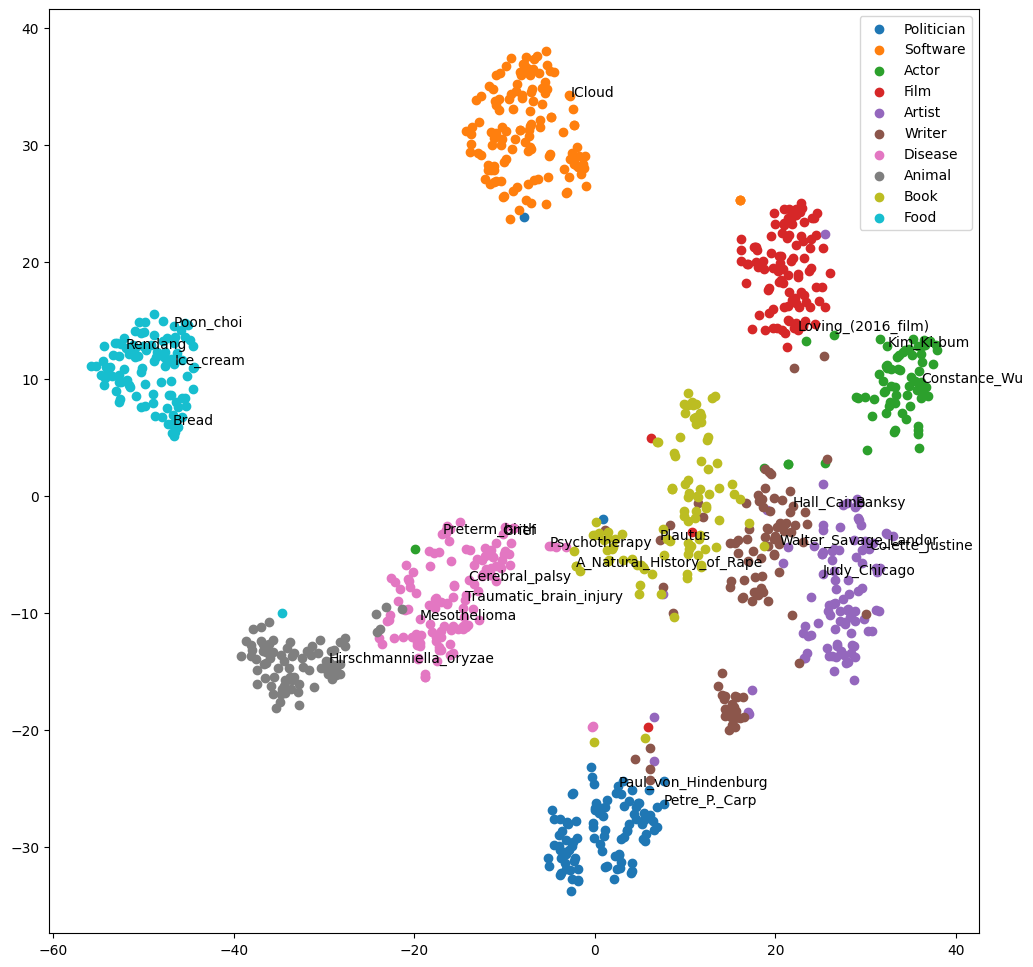

Use the first paragraph’s words and take an average on these embeddings:


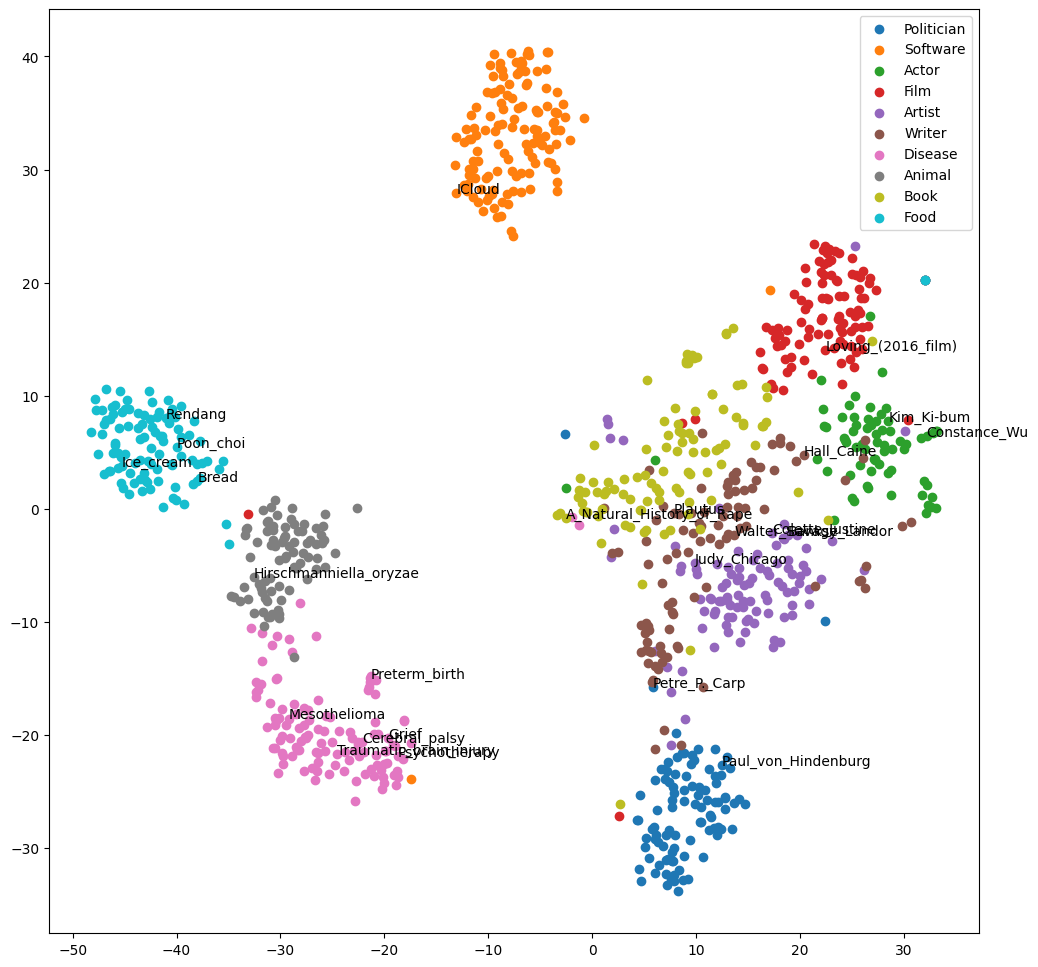

Use the doc2vec algorithm to present each document:


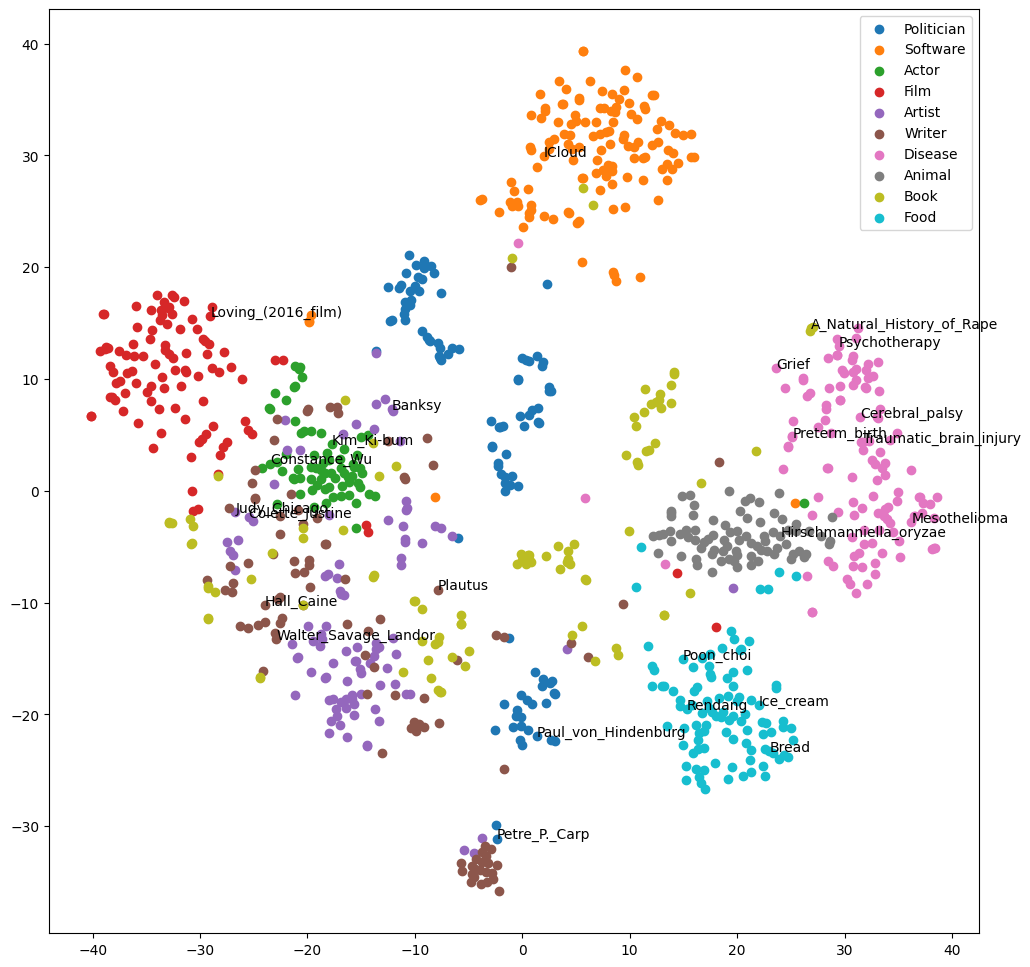

In [ ]:
for text, _model in models.items():
    print(text + ":")
    _model.tsne_plot()
